In [1]:
import os
import pandas as pd
import numpy as np
import random
import gc
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.feature_extraction.text import TfidfVectorizer
from  collections import Counter

np.random.seed(2019)
random.seed(2019)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 280)
pd.set_option('display.max_colwidth', 150)
data_path = '/data/workspace/kimi/tencent_ads/2020/dataset'
preprocess_path = 'preprocess'

In [2]:
clk_df = pd.read_csv(f'{data_path}/train_preliminary/click_log.csv' )



91
85    417797
78    406004
84    393253
64    388689
57    384115
74    381696
91    376422
63    376263
34    373768
36    371639
Name: time, dtype: int64
Int64Index([85, 78, 84, 64, 57, 74, 91, 63, 34, 36, 31, 77, 73, 43, 35, 75, 65, 37, 32, 33, 71, 56, 79, 67, 50, 70, 66, 88, 90, 81, 49, 82, 72, 83, 68, 80, 76, 86, 14, 55, 60, 54, 69, 87, 58, 42, 53, 61, 45, 52, 46, 22, 59, 40, 48, 89, 30, 51, 62, 41, 47, 15, 29, 44, 13, 39, 21,
            18, 28, 38,  1, 26, 17,  8, 19, 16, 25, 11,  7, 27, 23,  2, 24, 12, 10,  3, 20,  4,  5,  9,  6],
           dtype='int64')


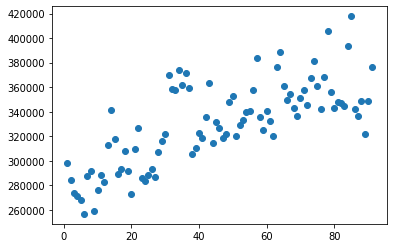

In [3]:
adv_count_value= clk_df['time'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
#null_counts = adv_count_value['\\N']
#print(f"null:{null_counts}")
x = adv_count_value.index
print(x)
y = adv_count_value.values
plt.scatter(x,y)
plt.show()

        user_id  click_times_total
697474   697475                 10
815798   815799                 10
815807   815808                 10
142089   142090                 10
339275   339276                 10
...         ...                ...
677300   677301               1669
178332   178333               1714
157584   157585               1742
674069   674070               1776
839367   839368              21330

[900000 rows x 2 columns]


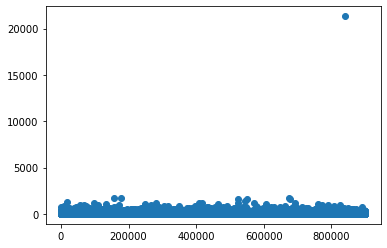

In [4]:
user_click_sum_df = clk_df.groupby(['user_id']).click_times.sum().reset_index().rename(columns={'click_times':'click_times_total'}).sort_values(by='click_times_total')
print(user_click_sum_df)
x = user_click_sum_df['user_id'].values.tolist()
y = user_click_sum_df['click_times_total'].values.tolist()
plt.scatter(x,y)
plt.show()

In [5]:
ad_df = pd.read_csv(f'{data_path}/train_preliminary/ad.csv' )

In [6]:
merged_df = clk_df.merge(ad_df,on='creative_id')
merged_df.replace("\\N",-1,inplace=True)
merged_df.fillna(-1).astype(float)
merged_df['wday'] = merged_df['time'].apply(lambda x :int(x /7))
merged_df['month'] = merged_df['time'].apply(lambda x :int(x /30))
print(merged_df)

          time  user_id  creative_id  click_times    ad_id product_id  product_category  advertiser_id industry  wday  month
0            9    30920       567330            1   504423      30673                 3          32638      319     1      0
1           15   320815       567330            1   504423      30673                 3          32638      319     2      0
2           11   355089       567330            1   504423      30673                 3          32638      319     1      0
3            9   363442       567330            1   504423      30673                 3          32638      319     1      0
4           14   370513       567330            1   504423      30673                 3          32638      319     2      0
...        ...      ...          ...          ...      ...        ...               ...            ...      ...   ...    ...
30082766    52   309198      2459911            1  2119242        161                 2            676      231     7      1


In [8]:
label_df = pd.read_csv(f'{data_path}/train_preliminary/user.csv')

In [7]:
grouped_df = merged_df.groupby(['user_id']).click_times.sum()

print(grouped_df)

user_id
1         14
2         46
3         30
4         29
5         34
          ..
899996    14
899997    20
899998    15
899999    22
900000    12
Name: click_times, Length: 900000, dtype: int64


In [27]:
long_seq_df = grouped_df[grouped_df>150].reset_index()
#long_seq_df = long_seq_df[long_seq_df.user_id > 720000]
print(long_seq_df)
print(long_seq_df[long_seq_df.user_id <= 720000])
print(long_seq_df[long_seq_df.user_id > 720000])

       user_id  click_times
0           97          160
1          127          184
2          211          315
3          260          153
4          344          181
...        ...          ...
13456   899825          303
13457   899897          156
13458   899903          174
13459   899986          151
13460   899991          153

[13461 rows x 2 columns]
       user_id  click_times
0           97          160
1          127          184
2          211          315
3          260          153
4          344          181
...        ...          ...
10829   719729          192
10830   719766          185
10831   719843          204
10832   719884          162
10833   719924          218

[10834 rows x 2 columns]
       user_id  click_times
10834   720021          260
10835   720064          153
10836   720309          178
10837   720326          216
10838   720396          293
...        ...          ...
13456   899825          303
13457   899897          156
13458   899903          

In [23]:
long_seq_target_df = long_seq_df.merge(label_df,on='user_id',how='left')
print(long_seq_target_df)

       user_id  click_times  age  gender
0           37          140    4       1
1           92          139    5       1
2           97          160    7       2
3          125          111    4       2
4          127          184    6       1
...        ...          ...  ...     ...
40086   899897          156    4       2
40087   899903          174    3       1
40088   899981          105    2       2
40089   899986          151    1       2
40090   899991          153    3       1

[40091 rows x 4 columns]


In [24]:
long_seq_target_age_value_counts =   long_seq_target_df['age'].value_counts()
print(long_seq_target_age_value_counts)

3     8343
2     6950
4     6405
5     5735
6     4205
7     2837
1     2296
8     1396
9     1018
10     906
Name: age, dtype: int64
